# Использование BERT для задачи классификации последовательности




[Исходный туториал](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) + материалы курса Кати Артемовой  на ФКН

**Важные ссылки про BERT**

[Devlin et al 2019](https://arxiv.org/pdf/1810.04805.pdf) - BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding - статья, презентующая BERT

[Vaswani et al 2017](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) - Attention is all you need - статья, презентующая трансформеры

[Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) by Jay Allamar - архитектура трансформера в картингах и гифках

[Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) by harvardnlp -код трансформера на торче, реализующий статью по абзацам

[Transformers](https://huggingface.co/transformers/) by hugging face -  главная open source библиотека, откуда можно брать предобученные бертоподобные модели


Сегодня посмотрим, как можно использовать BERT (или любую другую подобную модель) с помощью библиотеки Transformers.

Общий пайплайн:
BERT используется как начальный блок модели и считает контекстные вектора для слов.
Поверх этого блока мы добавляем "голову" модели, ее архитектура зависит от задачи.
Веса BERT предобучены, но мы проводим дообучение (fine-tuning) на целевой задаче.




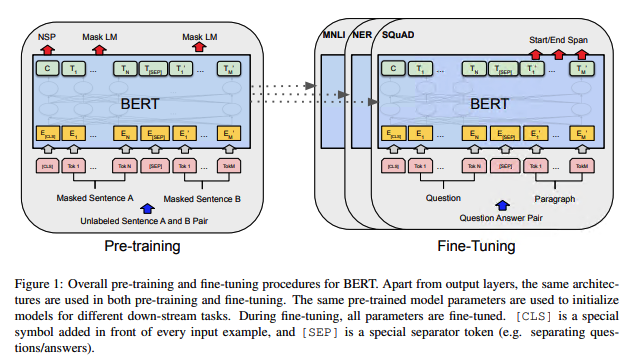

Наша сегодняшняя задача - классификация отзывов.
Данные - отзывы на приложения в Google Play, классы:  negative (1,2), neutral (3), positive (4,5)

# **Задание 1. 10 баллов (+2)**


Решите задачу классификации по тональности на подготовленном в одной из семинарских тетрадок корпусе отзывов Google Play, либо на корпусе IMDB, используя пайплайн с Trainer от HuggingFace.

обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) -- 2 балла

измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя. -- 3 балла

примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification) -- 2 балла

*4. агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса -- 2 дополнительных балла

выберите на сайте google play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей -- 2 балла
Общие требования: (1 балл)

Для всех моделей используйте одинаковые гиперпараметры, чтобы их результаты можно было сравнить между собой.

Комментируйте ваши решения в коде.

Для каждой из моделей нужно привести результаты на тестовой выборке.

Вы можете использовать любую предобученную модель, которая подходит для работы с английским, кроме bert-base-cased

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face

In [1]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.3 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.2.2
torch       : 2.5.1+cu121
transformers: 4.47.1



Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 91.1MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 46.9MB/s]


In [5]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [7]:
df = pd.read_csv("reviews.csv")

In [8]:
df.shape

(15746, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [10]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [11]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

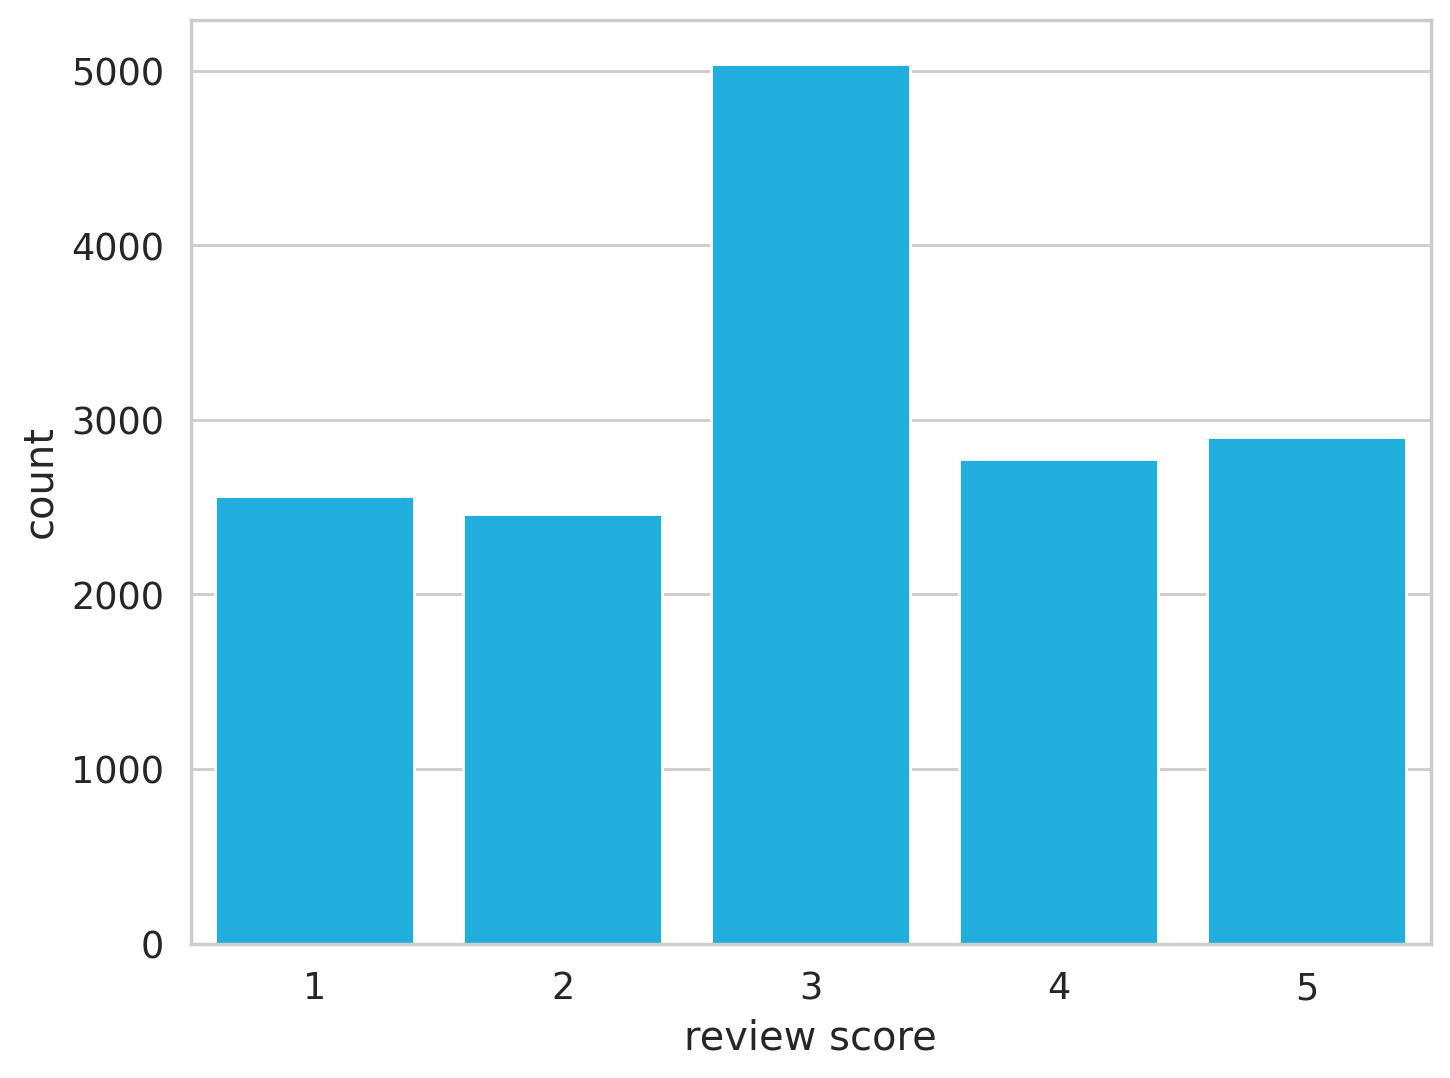

In [12]:
sns.countplot(x=df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы.
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [13]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [14]:
class_names = ['negative', 'neutral', 'positive']

<ipython-input-15-c8622670199a>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names);


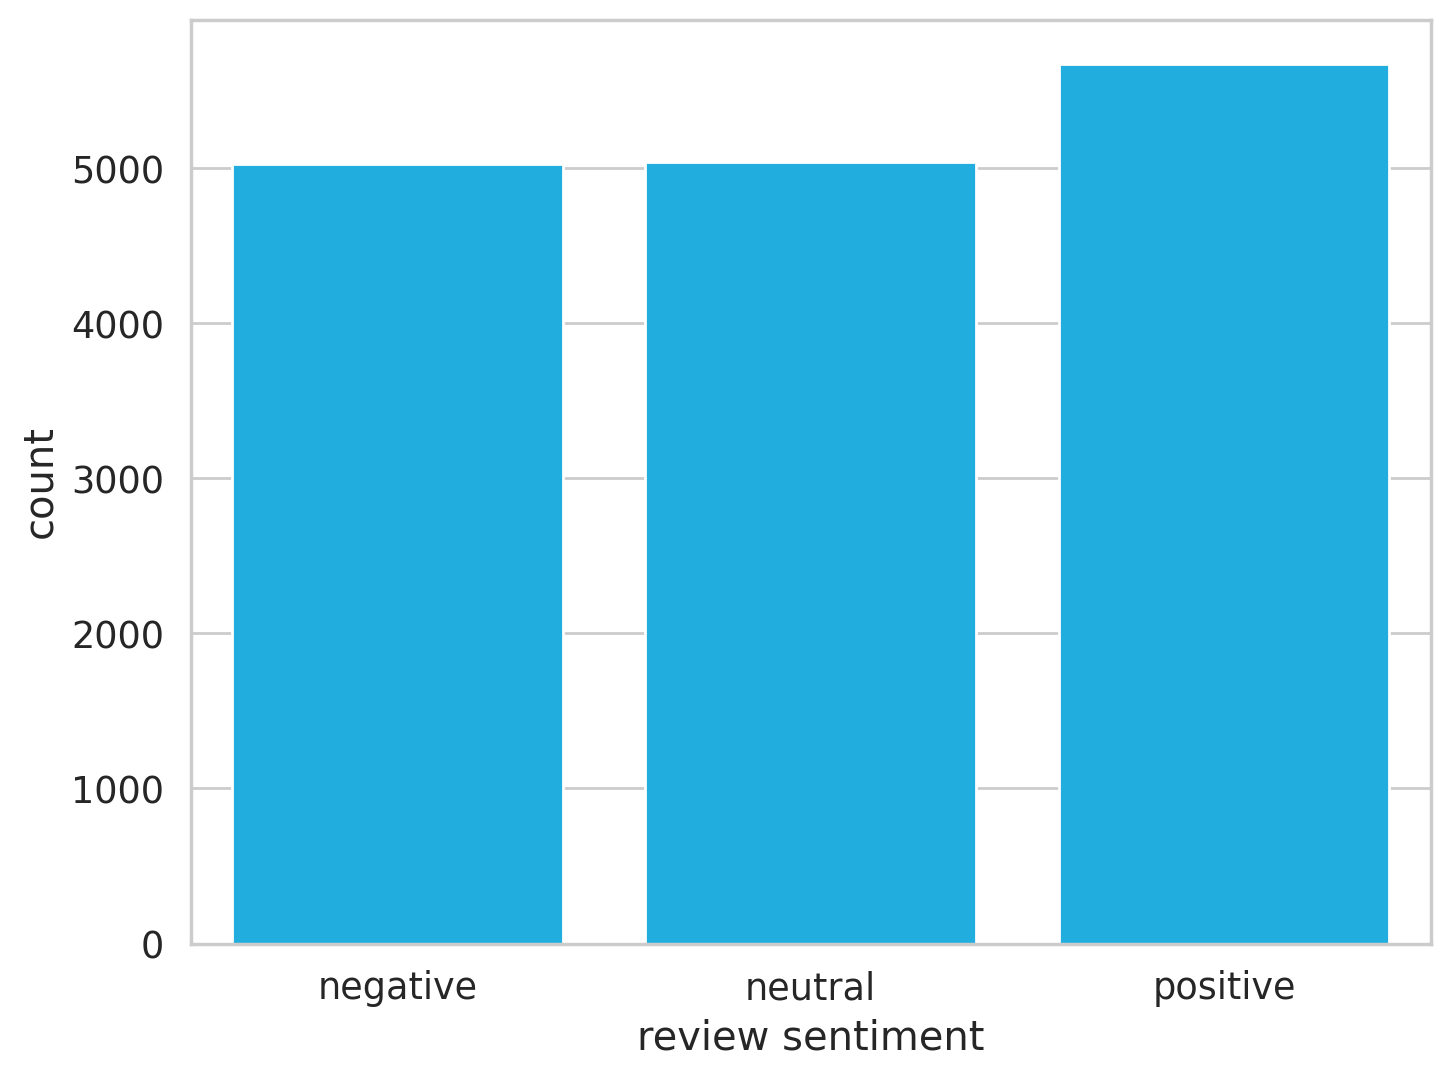

In [15]:
ax = sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

## Предобработка данных

Для обучение модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.



Бертоподобных моделей огромное множество, но если они интегрированы в библиотеку Transformers, сменить одну модель на другую очень просто. Вот [здесь](https://huggingface.co/transformers/pretrained_models.html) можно посмотреть, какие модели есть библиотеке.

Model id в таблице используются для двух вещей - подгрузки весов в саму модель и подгрузки правильного токенизатора. Вам не нужно самим добавлять спецсимволы и строить индексы словаря, это сделает токенайзер, соотвествующий выбранной модели.
Сегодняшний выбор - модель 'bert-base-cased'

In [ ]:
#from transformers import AutoTokenizer, AutoModelForMaskedLM
# Взяла отсюда: https://huggingface.co/google-bert/bert-base-uncased?library=transformers

In [16]:
PRE_TRAINED_MODEL_NAME = 'google-bert/bert-base-uncased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [17]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-cased-whole-word-masking")

Посмотрим, как работает модель токенизации для BERT.



In [18]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


In [19]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: He started a new book, it was quite readable
   Tokens: ['he', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able']
Token IDs: [2002, 2318, 1037, 2047, 2338, 1010, 2009, 2001, 3243, 3191, 3085]


##  Специальные токены

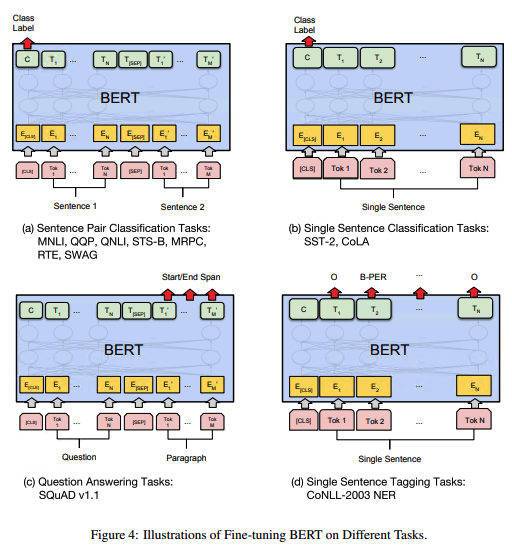



`[SEP]` - метка конца предложения


In [20]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [21]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [22]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Вся эта предобработка может быть сделана с помощью метода encode_plus

In [23]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2002, 2318, 1037, 2047, 2338, 1010, 2009, 2001, 3243, 3191, 3085,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Такая же длина будет и у *attention mask*

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['[CLS]',
 'he',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Установим максимальную длину последовательности равной 160

In [27]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [28]:

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки

In [29]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
device

device(type='cuda', index=0)

In [31]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))


Создадим итераторы по данным
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [35]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [36]:
data = next(iter(train_data_loader))

In [37]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['review_text'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

["You can't have your to do list as notifications", "I haven't been using this very long and it's not as user friendly as the Calender that came on my last phone.  I wish instead of dots you can just see what you have entered for that day immediately without tapping on that day.  Otherwise it is easy to use and functional.", '1. Кривой и неработающий экспорт и импорт. 2. Нельзя удалить базовые навыки, заданий и характеристики. 3. Нельзя удалять сразу несколько навыков, заданий и характеристик. 4. Кнопка отчислить данные не удаляет всё, а только откатывает к базовым. Спустя пару месяцев снова установил приложение. Загрузил с автосохронерия данных - загрузилось всё базовое и с диска тоже самое (настройки тоже). Проверял после установки изменяя данные и сохраняя их потом. Итог: после загрузки зброс к базовым.', 'Love it so far. Wish it had a widget for Android though.', "Liked the prioritization by dragging and the highlighting, but there does not seem to be a way to create recurring task

In [39]:
data['targets']

tensor([0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 0, 0, 0, 0, 2, 0])

## Классификация сентимента с использованием модели BERT от Hugging Face


В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [40]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [41]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Попробуем использовать эту модель

In [42]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'he',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [43]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [44]:
last_hidden_state, pooled_output, hidden_states = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  return_dict=False)


В переменную last_hidden_state теперь записана последовательность скрытых состояний последнего слоя модели.

In [45]:
print(last_hidden_state.shape)
print(pooled_output.shape)
print(len(hidden_states))

torch.Size([1, 32, 768])
torch.Size([1, 768])
13


In [46]:
for state in hidden_states:
  print(state.shape)

torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])


Посмотрим на BERT эмбеддинги некоторых слов в предложениях.

In [47]:
text1 = df.loc[16]['content']
text2 = df.loc[338]['content']
print(text1)
print(text2)

Couldn't even set up one single recurring reminder without being required to pay monthly subscription. Get your greedy hand off it dev. It's only only a reminder app not a useful service.
Well designed and all however alot of the crutial features are locked behind the premium which u need to pay for


In [48]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer2 = PreTrainedTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [49]:
tokenizer2.sep_token = tokenizer.sep_token
tokenizer2.pad_token = tokenizer.pad_token

In [50]:
encoding = tokenizer.encode_plus(
  text1,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

In [51]:
encoding2 = tokenizer2.encode_plus(
  text1,
  max_length=50,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True,
  return_offsets_mapping=True
)

In [52]:
print(encoding.keys())
print(encoding2.keys())

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])


In [53]:
encoding2['offset_mapping']

tensor([[[  0,   0],
         [  0,   6],
         [  6,   7],
         [  7,   8],
         [  9,  13],
         [ 14,  17],
         [ 18,  20],
         [ 21,  24],
         [ 25,  31],
         [ 32,  41],
         [ 42,  50],
         [ 51,  58],
         [ 59,  64],
         [ 65,  73],
         [ 74,  76],
         [ 77,  80],
         [ 81,  88],
         [ 89, 101],
         [101, 102],
         [103, 106],
         [107, 111],
         [112, 118],
         [119, 123],
         [124, 127],
         [128, 130],
         [131, 134],
         [134, 135],
         [136, 138],
         [138, 139],
         [139, 140],
         [141, 145],
         [146, 150],
         [151, 152],
         [153, 161],
         [162, 165],
         [166, 169],
         [170, 171],
         [172, 178],
         [179, 186],
         [186, 187],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0

In [54]:
encoding['input_ids']

tensor([[  101,  2481,  1005,  1056,  2130,  2275,  2039,  2028,  2309, 10694,
         14764,  2302,  2108,  3223,  2000,  3477,  7058, 15002,  1012,  2131,
          2115, 20505,  2192,  2125,  2009, 16475,  1012,  2009,  1005,   102]])

In [55]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict=False)

In [56]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'couldn', "'", 't', 'even', 'set', 'up', 'one', 'single', 'recurring', 'reminder', 'without', 'being', 'required', 'to', 'pay', 'monthly', 'subscription', '.', 'get', 'your', 'greedy', 'hand', 'off', 'it', 'dev', '.', 'it', "'", '[SEP]']


In [57]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')

17

In [58]:
emb1 = last_hidden_state[0, 17]
emb1.shape

torch.Size([768])

In [59]:
encoding2 = tokenizer.encode_plus(
  text2,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

last_hidden_state2, pooled_output2 = bert_model(
  input_ids=encoding2['input_ids'],
  attention_mask=encoding2['attention_mask'],
  return_dict=False)

In [60]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0])

['[CLS]',
 'well',
 'designed',
 'and',
 'all',
 'however',
 'al',
 '##ot',
 'of',
 'the',
 'cr',
 '##uti',
 '##al',
 'features',
 'are',
 'locked',
 'behind',
 'the',
 'premium',
 'which',
 'u',
 'need',
 'to',
 'pay',
 'for',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [61]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index('premium')

18

In [62]:
emb2 = last_hidden_state2[0, 1]
emb2.shape

torch.Size([768])

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

In [64]:
cosine_similarity( [emb1.detach().cpu().numpy()], [emb2.detach().cpu().numpy()])

array([[0.2487692]], dtype=float32)

Опишем наконец наш классификатор на основе BertModel

In [65]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [66]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [67]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

Перенесем на GPU один из наших батчей (для примера).

In [68]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


Применим модель к данным.

In [69]:
output = model(input_ids, attention_mask)
output

tensor([[ 0.4403, -0.5204, -0.6500],
        [ 0.1137, -0.4435, -0.4563],
        [-0.1626,  0.1534, -0.1173],
        [ 0.2407, -0.3659, -0.1775],
        [ 0.0333, -0.2689, -0.2917],
        [ 0.2219,  0.0510, -0.2371],
        [-0.2436, -0.4242, -0.3342],
        [ 0.4689, -0.4074, -0.5399],
        [ 0.1587, -0.1000,  0.0240],
        [ 0.3366, -0.1122, -0.2344],
        [ 0.2503, -0.2995, -0.4393],
        [ 0.1848,  0.0218, -0.1260],
        [ 0.1181, -0.6058, -0.6131],
        [-0.3773, -0.1019, -0.3994],
        [ 0.1712,  0.1388, -0.3302],
        [ 0.1763, -0.2801, -0.5435]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Если хотим получить вероятности классов, применяем SoftMax к выходу модели.

In [70]:
F.softmax(output, dim=1)

tensor([[0.5818, 0.2226, 0.1956],
        [0.4676, 0.2679, 0.2645],
        [0.2926, 0.4013, 0.3061],
        [0.4538, 0.2474, 0.2987],
        [0.4062, 0.3003, 0.2935],
        [0.4041, 0.3406, 0.2553],
        [0.3639, 0.3037, 0.3324],
        [0.5615, 0.2338, 0.2047],
        [0.3779, 0.2918, 0.3303],
        [0.4539, 0.2897, 0.2564],
        [0.4810, 0.2776, 0.2414],
        [0.3872, 0.3290, 0.2838],
        [0.5086, 0.2466, 0.2448],
        [0.3035, 0.3997, 0.2968],
        [0.3885, 0.3761, 0.2353],
        [0.4716, 0.2988, 0.2296]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Обучение модели

Для дообучения модели будем использовать оптимизатор [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face.



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [71]:
#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False


In [72]:
list(model.bert.encoder.layer[3].parameters())[0]

Parameter containing:
tensor([[ 0.0586, -0.0279,  0.0022,  ..., -0.0205,  0.0419,  0.0560],
        [-0.0011,  0.1283, -0.0564,  ..., -0.0514, -0.0199,  0.0516],
        [-0.0083,  0.0060, -0.0469,  ...,  0.0569, -0.0073, -0.0616],
        ...,
        [ 0.0118,  0.0645, -0.0159,  ..., -0.0027, -0.0031, -0.0141],
        [ 0.0029,  0.0531,  0.0221,  ..., -0.0047,  0.0399,  0.0344],
        [ 0.0512,  0.0246,  0.0077,  ...,  0.0108,  0.0262,  0.0081]],
       device='cuda:0')

In [73]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения

Также реализуем функцию для оценки качества модели на данных из data_loader

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели

In [74]:
from tqdm import tqdm
# не люблю, когда не могу отслеживать прогресс, поэтому добавлю tqdm
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  # Оборачиваю data_loader в tqdm для отображения прогресса
  for d in tqdm(data_loader, desc="Training"):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    # Оборачиваю data_loader в tqdm для отображения прогресса
    for d in tqdm(data_loader, desc="Evaluating"):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


Training: 100%|██████████| 886/886 [04:58<00:00,  2.97it/s]


Train loss 0.712084994022787 accuracy 0.6746878027915955


Evaluating: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


Val loss 0.5937318152189255 accuracy 0.7318932414054871

Epoch 2/2
----------


Training: 100%|██████████| 886/886 [05:14<00:00,  2.82it/s]


Train loss 0.4961818695808372 accuracy 0.7940160036087036


Evaluating: 100%|██████████| 50/50 [00:06<00:00,  7.63it/s]


Val loss 0.5557140693068504 accuracy 0.7763659358024597



In [ ]:
torch.cuda.empty_cache()


При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

In [75]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

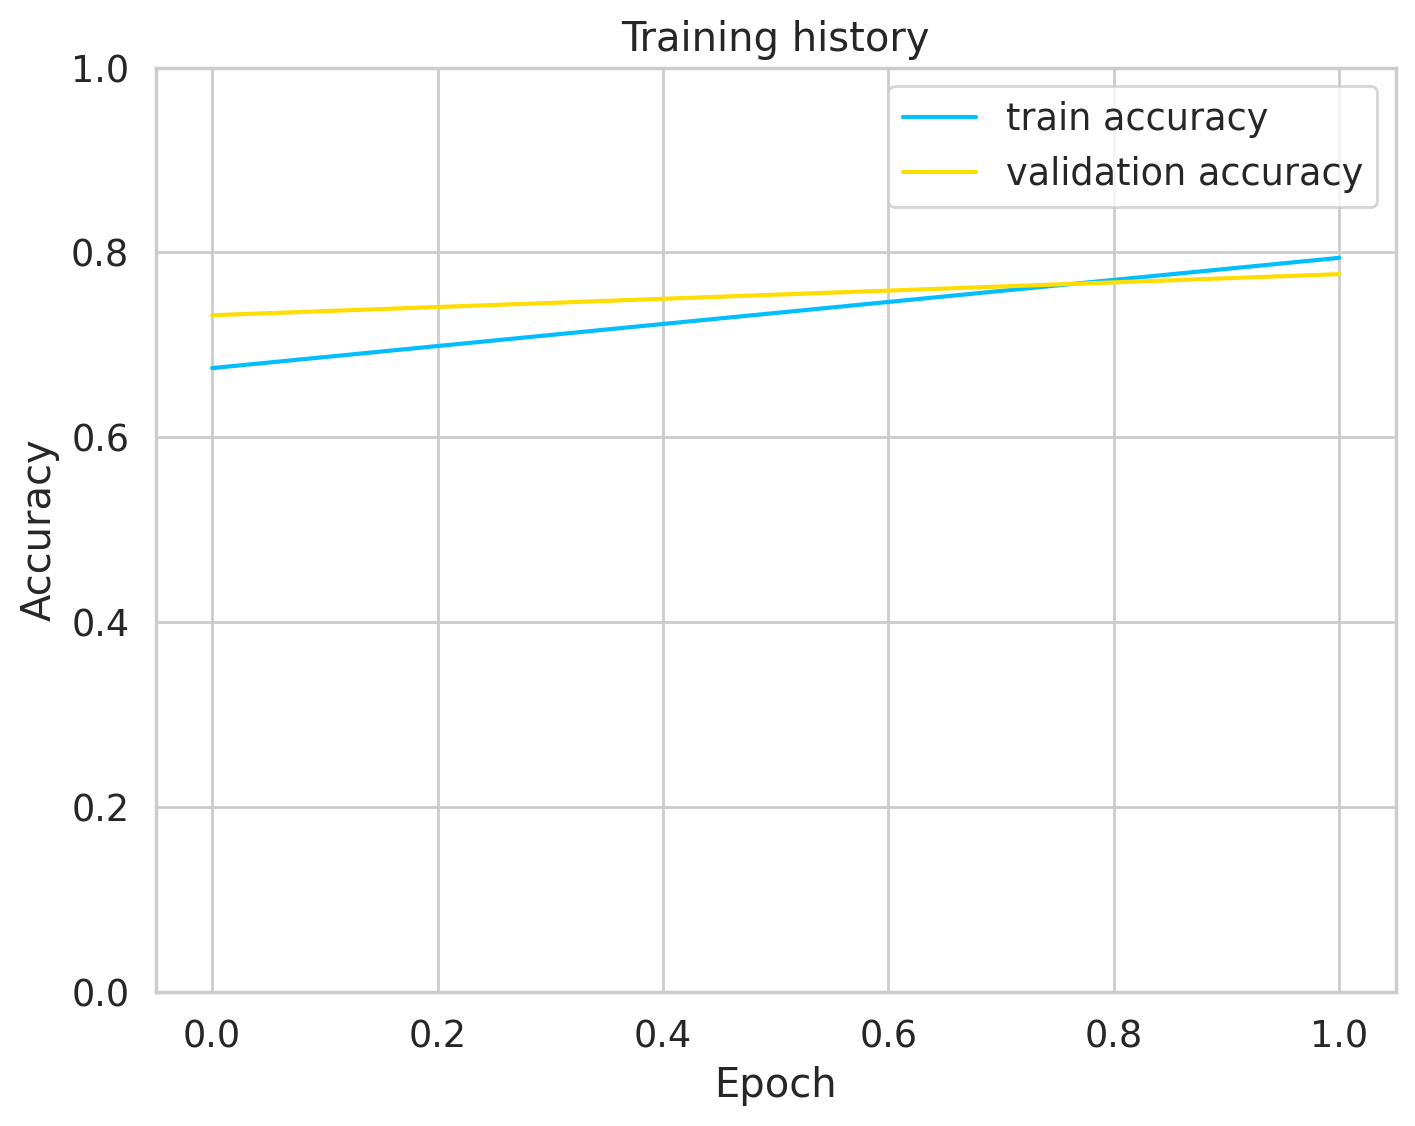

In [76]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
'''
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)
'''

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [77]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 50/50 [00:06<00:00,  7.81it/s]


0.7664974331855774



# **Примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification)**

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

In [144]:
print(df.columns)

Index(['userName', 'userImage', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'sortOrder',
       'appId', 'sentiment'],
      dtype='object')


Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [78]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [79]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [80]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.80      0.75      0.77       245
     neutral       0.65      0.67      0.66       254
    positive       0.84      0.87      0.85       289

    accuracy                           0.77       788
   macro avg       0.76      0.76      0.76       788
weighted avg       0.77      0.77      0.77       788




# **Примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification)**

In [155]:
#import os
#os.environ["WANDB_DISABLED"] = "true"

In [168]:
#df.rename(columns={"score": "label"}, inplace=True)
# Verify the change
#print(df.head())

           userName                                          userImage  \
0     Andrew Thomas  https://lh3.googleusercontent.com/a-/AOh14GiHd...   
1      Craig Haines  https://lh3.googleusercontent.com/-hoe0kwSJgPQ...   
2     steven adkins  https://lh3.googleusercontent.com/a-/AOh14GiXw...   
3  Lars Panzerbjørn  https://lh3.googleusercontent.com/a-/AOh14Gg-h...   
4     Scott Prewitt  https://lh3.googleusercontent.com/-K-X1-YsVd6U...   

                                             content  labels  thumbsUpCount  \
0  Update: After getting a response from the deve...       1             21   
1  Used it for a fair amount of time without any ...       1             11   
2  Your app sucks now!!!!! Used to be good but no...       1             17   
3  It seems OK, but very basic. Recurring tasks n...       1            192   
4  Absolutely worthless. This app runs a prohibit...       1             42   

  reviewCreatedVersion                   at  \
0             4.17.0.3  2020-04-0

In [169]:
#df.head()

,userName,userImage,content,labels,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


In [175]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted') # потому что multiclass
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [176]:
from transformers import Trainer, TrainingArguments, BertForSequenceClassification
#тренировочные параметры
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to='none', # отключила wandb
)

In [177]:
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [178]:
trainer = Trainer(
    model=model,   # наша модель
    args=training_args,  # параметры
    train_dataset=train_data_loader.dataset,  # датасет для трейна
    eval_dataset=val_data_loader.dataset,  # валидационный датасет
    compute_metrics=compute_metrics,   # метрики
)

In [179]:
trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.

In [ ]:
trainer.evaluate()

In [ ]:
trainer.evaluate(eval_dataset=test_data_loader.dataset, metric_key_prefix="test")

# **обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки)**

In [ ]:
class Classifier(nn.Module):

  def __init__(self, n_classes): # здесь приписываем берту свою голову
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # в конфиге скрытый размер

  def forward(self, input_ids, attention_mask, labels=None):
     outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
     pooled_output = outputs[1]
    # classifier head
     logits = self.classifier(pooled_output)

     loss = None
     if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

     return {'loss': loss, 'logits': logits}

In [ ]:
model = Classifier(n_classes=3)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_loader.dataset,
    eval_dataset=val_data_loader.dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.evaluate(eval_dataset=test_data_loader.dataset, metric_key_prefix="test")

# **измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя**

In [ ]:
class Classifier2(nn.Module):

  def __init__(self, n_classes): # здесь приписываем берту свою голову
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.classifier = nn.Linear(self.bert.config.hidden_size * 2, n_classes) # в конфиге скрытый размер удвоение скрытого размера для конкатенации

  def forward(self, input_ids, attention_mask, labels=None):
     outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
     pooled_output = outputs[1]  # аутпут с пуллер слоя

     pooled_output = outputs.pooler_output
     cls_token_emb = outputs.last_hidden_state[:, 0, :] # 1st token in the input sequence = index 0 of the sequence_length dim

     # соединяем их
     combined_output = torch.cat((pooled_output, cls_token_emb), dim=1)

     logits = self.classifier(combined_output)

     loss = None
     if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

     return {'loss': loss, 'logits': logits}

In [ ]:
model = Classifier2(n_classes=3)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_loader.dataset,
    eval_dataset=val_data_loader.dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.evaluate(eval_dataset=test_data_loader.dataset, metric_key_prefix="test")

# **Дальше не нужно смотреть, это пример на семинаре**

Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы.

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы.

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

##Trainer от HuggingFace

Библиотека HuggingFace предоставляет инструменты, которые упрощают обучение и оценку моделей, выложенных в репозиторий библиотеки. Рассмотрим эти инструменты на примере задачи анализа тональности. Будем обучать и оценивать модели на датасете imdb, состоящем из отзывов пользователей о фильмах.

Оригинал: https://huggingface.co/transformers/custom_datasets.html#sequence-classification-with-imdb-reviews

Для загрузки датасета воспользуемся библиотекой datasets, реализованной HuggingFace. Данная библиотека предоставляет возможность быстро и удобно скачивать различные бенчмарки: https://huggingface.co/datasets

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')

In [ ]:
imdb_dataset

In [ ]:
imdb_dataset["train"]["text"][:10]

In [ ]:
imdb_dataset["train"]["label"][:10]

Сократим количество примеров, чтобы процесс обучения был быстрее.

In [ ]:
train_texts = imdb_dataset["train"]["text"][:2000]
train_labels = imdb_dataset["train"]["label"][:2000]
test_texts = imdb_dataset["test"]["text"][:1000]
test_labels = imdb_dataset["test"]["label"][:1000]

In [ ]:
del imdb_dataset

Выделим часть обучающих данных для оценки:

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

Токенизируем данные

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Создадим класс Dataset, который на каждой итерации будет возвращать токенизированный отзыв и класс:

In [ ]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

Опишем функцию для подсчета метрик, которые хотим увидеть при оценке модели (по умолчанию будет вычисляться только loss):

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Зададим параметры обучения с помощью TrainingArguments:

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

Инициализируем модель и запустим fine-tune ее с помощью модуля Trainer. В данном модуле будет автоматически происходить итерация по эпохам, батчам, рассчет функции потерь и градиентов, ничего этого больше руками прописывать не нужно!

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [ ]:
trainer.evaluate()

Оценим модель на тестовых данных

In [ ]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")